# Input data

In [1]:
import scipy.io as spio
import numpy as np

In [2]:
# Reading the data for the Face from all the subjects
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

In [3]:
# Deviding the input data into train and validation
# For creating the training and testing set, 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(BahramFace['Intensification_Data'].shape[0] * 0.30)
length

1080

In [4]:
FacesDataAll = np.vstack(tup=(BahramFace['Intensification_Data'][:], 
                       DJFace['Intensification_Data'][:], 
                       NickFace['Intensification_Data'][:],
                      RoohiFace['Intensification_Data'][:],
                      SarahFace['Intensification_Data'][:]))

FacesDataTrainAll = np.vstack(tup=(BahramFace['Intensification_Data'][:-length], 
                       DJFace['Intensification_Data'][:-length], 
                       NickFace['Intensification_Data'][:-length],
                      RoohiFace['Intensification_Data'][:-length],
                      SarahFace['Intensification_Data'][:-length]))

FacesDataTest = np.vstack(tup=(BahramFace['Intensification_Data'][-length:], 
                       DJFace['Intensification_Data'][-length:], 
                       NickFace['Intensification_Data'][-length:],
                      RoohiFace['Intensification_Data'][-length:],
                      SarahFace['Intensification_Data'][-length:]))

In [5]:
(FacesDataAll.shape, FacesDataAll.dtype, 
 FacesDataTest.shape, FacesDataTest.dtype, 
 FacesDataTrainAll.shape, FacesDataTrainAll.dtype)

((18720, 205, 16),
 dtype('<f8'),
 (5400, 205, 16),
 dtype('<f8'),
 (13320, 205, 16),
 dtype('<f8'))

In [6]:
BahramFaceDataTrain = BahramFace['Intensification_Data'][:-length]
DJFaceDataTrain = DJFace['Intensification_Data'][:-length]
NickFaceDataTrain = NickFace['Intensification_Data'][:-length]
RoohiFaceDataTrain = RoohiFace['Intensification_Data'][:-length]
SarahFaceDataTrain = SarahFace['Intensification_Data'][:-length]

In [7]:
# 30% of the total training data is validation,
# 70% of the total training data is training
# This is applied to every single subject data.
length2 = int(BahramFaceDataTrain.shape[0] * 0.30)
length2

756

In [8]:
FacesDataTrain = np.vstack(tup=(BahramFaceDataTrain[:-length2], 
                       DJFaceDataTrain[:-length2], 
                       NickFaceDataTrain[:-length2],
                      RoohiFaceDataTrain[:-length2],
                      SarahFaceDataTrain[:-length2]))

FacesDataValid = np.vstack(tup=(BahramFaceDataTrain[-length2:], 
                       DJFaceDataTrain[-length2:], 
                       NickFaceDataTrain[-length2:],
                      RoohiFaceDataTrain[-length2:],
                      SarahFaceDataTrain[-length2:]))

In [9]:
(FacesDataTrainAll.shape, FacesDataTrainAll.dtype, 
 FacesDataTrain.shape, FacesDataTrain.dtype, 
 FacesDataValid.shape, FacesDataValid.dtype)

((13320, 205, 16),
 dtype('<f8'),
 (9540, 205, 16),
 dtype('<f8'),
 (3780, 205, 16),
 dtype('<f8'))

In [14]:
FacesLabelAll = np.vstack(tup=(BahramFace['Intensification_Label'][:], 
                       DJFace['Intensification_Label'][:], 
                       NickFace['Intensification_Label'][:],
                      RoohiFace['Intensification_Label'][:],
                      SarahFace['Intensification_Label'][:]))

FacesLabelTrainAll = np.vstack(tup=(BahramFace['Intensification_Label'][:-length], 
                       DJFace['Intensification_Label'][:-length], 
                       NickFace['Intensification_Label'][:-length],
                      RoohiFace['Intensification_Label'][:-length],
                      SarahFace['Intensification_Label'][:-length]))

FacesLabelTest = np.vstack(tup=(BahramFace['Intensification_Label'][-length:], 
                       DJFace['Intensification_Label'][-length:], 
                       NickFace['Intensification_Label'][-length:],
                      RoohiFace['Intensification_Label'][-length:],
                      SarahFace['Intensification_Label'][-length:]))

In [15]:
(FacesLabelAll.shape, FacesLabelAll.dtype,
 FacesLabelTest.shape, FacesLabelTest.dtype, 
 FacesLabelTrainAll.shape, FacesLabelTrainAll.dtype)

((18720, 1),
 dtype('uint8'),
 (5400, 1),
 dtype('uint8'),
 (13320, 1),
 dtype('uint8'))

In [16]:
BahramFaceLabelTrain = BahramFace['Intensification_Label'][:-length]
DJFaceLabelTrain = DJFace['Intensification_Label'][:-length]
NickFaceLabelTrain = NickFace['Intensification_Label'][:-length]
RoohiFaceLabelTrain = RoohiFace['Intensification_Label'][:-length]
SarahFaceLabelTrain = SarahFace['Intensification_Label'][:-length]

In [17]:
FacesLabelTrain = np.vstack(tup=(BahramFaceLabelTrain[:-length2], 
                       DJFaceLabelTrain[:-length2], 
                       NickFaceLabelTrain[:-length2],
                      RoohiFaceLabelTrain[:-length2],
                      SarahFaceLabelTrain[:-length2]))

FacesLabelValid = np.vstack(tup=(BahramFaceLabelTrain[-length2:], 
                       DJFaceLabelTrain[-length2:], 
                       NickFaceLabelTrain[-length2:],
                      RoohiFaceLabelTrain[-length2:],
                      SarahFaceLabelTrain[-length2:]))

In [18]:
# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [19]:
# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=FacesDataTrain)
X_valid_norm = normalize(inputs=FacesDataValid)
X_test_norm = normalize(inputs=FacesDataTest)

In [20]:
(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

((9540, 205, 16),
 dtype('<f8'),
 (3780, 205, 16),
 dtype('<f8'),
 (5400, 205, 16),
 dtype('<f8'))

### Hyperparameters

In [21]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 1000 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = FacesLabelAll.max() + 1

# Tweekable parameters
learning_rate = 0.0001 #1e-4
epochs = 5 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [22]:
Y_train = np.array(FacesLabelTrain, dtype=int).reshape(-1)
Y_valid = np.array(FacesLabelValid, dtype=int).reshape(-1)
Y_test = np.array(FacesLabelTest, dtype=int).reshape(-1)

In [23]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

In [24]:
(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

((9540, 2),
 (3780, 2),
 (5400, 2),
 (9540, 205, 16),
 (3780, 205, 16),
 (5400, 205, 16))

In [25]:
(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

(dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('<f8'),
 dtype('<f8'),
 dtype('<f8'))

# GPUs or CPU

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [27]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name = 'labels_')
is_train = tf.placeholder(dtype=tf.bool, shape=None, name='is_train')
keep_prob_ = tf.placeholder(dtype=tf.float32, shape=None, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, shape=None, name = 'learning_rate_')

# Forward pass: Convolutional Layers, FC Layer, and Output layer

In [28]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=32, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
if is_train is True:
    out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 49, 64)
# (101 - 5 + 0)/2 + 1 = (96/2)+1= 48+1= 49
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=64, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
if is_train is True:
    out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 49, 64) --> (batch, 49*64) --> (batch, 49*64*2)
# 49*64 = 50*64 - 1*64 = 3200 - 64 = 3136, 3136*2 = 6272
# (batch, 49, 64) --> (batch, 3200) --> (batch, 6272)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 49*64))
out_fc = tf.layers.dense(inputs=in_fc, units=49*64*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
if is_train is True:
    out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 49, 64)
(?, 3136) (?, 6272)
(?, 2)


# Backward pass: error backpropagation

In [29]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

# Train the network

In [30]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, is_train: True, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
        # Feed dictionary of validation full-batch 
        # no dropout/keep_prob; no learning rate/ no learning
        feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, is_train: False}
        valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

        # Print at each iter/ epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(train_loss),
              "Valid loss: {:.6f}".format(valid_loss),
              "train acc: {:.6f}".format(train_acc),
              "Valid acc: {:.6f}".format(valid_acc))

        # Ploting the learning curve for training and validation
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
            
    # Testing after all epochs for the final model
    # Feed dictionary of testing full-batch similar to validation
    # no dropout/keep_prob; no learning rate/ no learning
    feed = {inputs_:X_test_norm, labels_:Y_test_onehot, is_train: False}
    loss, acc = sess.run([cost, accuracy], feed_dict = feed)
    print("Testing loss: {:.6f}".format(loss), 
         "Testing acc: {:.6f}".format(acc))

Epoch: 1/5 Train loss: 0.700302 Valid loss: 0.501393 train acc: 0.666667 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.403484 Valid loss: 0.749824 train acc: 0.888889 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.877257 Valid loss: 0.803353 train acc: 0.666667 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.054012 Valid loss: 0.885074 train acc: 1.000000 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.426993 Valid loss: 0.914124 train acc: 0.888889 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.721729 Valid loss: 0.864151 train acc: 0.777778 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.624457 Valid loss: 0.769325 train acc: 0.777778 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.340967 Valid loss: 0.684081 train acc: 0.888889 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.592538 Valid loss: 0.587514 train acc: 0.777778 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.497347 Valid loss: 0.504931 train acc: 0.777778 Valid acc: 0.833333
Epoch: 1/5 Train loss: 0.260758 Valid loss: 0.463106 train acc: 0.8888

Epoch: 1/5 Train loss: 0.093271 Valid loss: 0.468829 train acc: 1.000000 Valid acc: 0.844709
Epoch: 1/5 Train loss: 0.168876 Valid loss: 0.464478 train acc: 1.000000 Valid acc: 0.845238
Epoch: 1/5 Train loss: 0.297464 Valid loss: 0.476882 train acc: 0.888889 Valid acc: 0.845767
Epoch: 1/5 Train loss: 0.267806 Valid loss: 0.487995 train acc: 0.888889 Valid acc: 0.844709
Epoch: 1/5 Train loss: 0.191460 Valid loss: 0.494975 train acc: 1.000000 Valid acc: 0.843651
Epoch: 1/5 Train loss: 0.345200 Valid loss: 0.505041 train acc: 0.888889 Valid acc: 0.843386
Epoch: 1/5 Train loss: 0.134549 Valid loss: 0.535494 train acc: 1.000000 Valid acc: 0.843916
Epoch: 1/5 Train loss: 0.607206 Valid loss: 0.534494 train acc: 0.777778 Valid acc: 0.842857
Epoch: 1/5 Train loss: 0.326984 Valid loss: 0.524984 train acc: 0.888889 Valid acc: 0.842857
Epoch: 1/5 Train loss: 0.291811 Valid loss: 0.505614 train acc: 0.888889 Valid acc: 0.847355
Epoch: 1/5 Train loss: 0.108234 Valid loss: 0.496147 train acc: 1.0000

Epoch: 1/5 Train loss: 0.249827 Valid loss: 0.555578 train acc: 0.888889 Valid acc: 0.848942
Epoch: 1/5 Train loss: 0.438440 Valid loss: 0.596659 train acc: 0.888889 Valid acc: 0.844709
Epoch: 1/5 Train loss: 0.392878 Valid loss: 0.622370 train acc: 0.888889 Valid acc: 0.844974
Epoch: 1/5 Train loss: 0.060298 Valid loss: 0.643417 train acc: 1.000000 Valid acc: 0.842593
Epoch: 1/5 Train loss: 0.589859 Valid loss: 0.638876 train acc: 0.666667 Valid acc: 0.843122
Epoch: 1/5 Train loss: 0.139762 Valid loss: 0.634036 train acc: 0.888889 Valid acc: 0.842064
Epoch: 1/5 Train loss: 0.125318 Valid loss: 0.623657 train acc: 0.888889 Valid acc: 0.842328
Epoch: 1/5 Train loss: 0.802078 Valid loss: 0.596242 train acc: 0.777778 Valid acc: 0.844180
Epoch: 1/5 Train loss: 0.120244 Valid loss: 0.570131 train acc: 1.000000 Valid acc: 0.843915
Epoch: 1/5 Train loss: 0.223534 Valid loss: 0.544588 train acc: 0.888889 Valid acc: 0.845238
Epoch: 1/5 Train loss: 0.344754 Valid loss: 0.530520 train acc: 0.8888

Epoch: 1/5 Train loss: 0.038875 Valid loss: 0.509132 train acc: 1.000000 Valid acc: 0.858201
Epoch: 1/5 Train loss: 0.027806 Valid loss: 0.488983 train acc: 1.000000 Valid acc: 0.859524
Epoch: 1/5 Train loss: 0.375917 Valid loss: 0.475656 train acc: 0.777778 Valid acc: 0.860053
Epoch: 1/5 Train loss: 0.046468 Valid loss: 0.471857 train acc: 1.000000 Valid acc: 0.860847
Epoch: 1/5 Train loss: 0.044744 Valid loss: 0.474751 train acc: 1.000000 Valid acc: 0.861376
Epoch: 1/5 Train loss: 0.151326 Valid loss: 0.474445 train acc: 0.888889 Valid acc: 0.861905
Epoch: 1/5 Train loss: 0.105057 Valid loss: 0.459666 train acc: 1.000000 Valid acc: 0.862699
Epoch: 1/5 Train loss: 0.363021 Valid loss: 0.442134 train acc: 0.777778 Valid acc: 0.865080
Epoch: 1/5 Train loss: 0.067228 Valid loss: 0.433811 train acc: 1.000000 Valid acc: 0.864550
Epoch: 1/5 Train loss: 0.167272 Valid loss: 0.439626 train acc: 0.888889 Valid acc: 0.864550
Epoch: 1/5 Train loss: 0.099413 Valid loss: 0.452843 train acc: 1.0000

Epoch: 1/5 Train loss: 0.025015 Valid loss: 0.503386 train acc: 1.000000 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.112390 Valid loss: 0.509062 train acc: 1.000000 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.215094 Valid loss: 0.503701 train acc: 0.888889 Valid acc: 0.869048
Epoch: 1/5 Train loss: 0.215532 Valid loss: 0.498340 train acc: 0.888889 Valid acc: 0.869048
Epoch: 1/5 Train loss: 0.025518 Valid loss: 0.495437 train acc: 1.000000 Valid acc: 0.869312
Epoch: 1/5 Train loss: 0.591385 Valid loss: 0.491000 train acc: 0.777778 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.156562 Valid loss: 0.497774 train acc: 1.000000 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.095599 Valid loss: 0.496752 train acc: 0.888889 Valid acc: 0.869048
Epoch: 1/5 Train loss: 0.310888 Valid loss: 0.503494 train acc: 0.888889 Valid acc: 0.869577
Epoch: 1/5 Train loss: 0.011074 Valid loss: 0.510792 train acc: 1.000000 Valid acc: 0.868254
Epoch: 1/5 Train loss: 0.090731 Valid loss: 0.519360 train acc: 1.0000

Epoch: 1/5 Train loss: 0.349545 Valid loss: 0.365043 train acc: 0.888889 Valid acc: 0.861905
Epoch: 1/5 Train loss: 0.157761 Valid loss: 0.361665 train acc: 1.000000 Valid acc: 0.864286
Epoch: 1/5 Train loss: 1.020494 Valid loss: 0.359740 train acc: 0.888889 Valid acc: 0.865873
Epoch: 1/5 Train loss: 0.294842 Valid loss: 0.357361 train acc: 0.888889 Valid acc: 0.867196
Epoch: 1/5 Train loss: 0.228329 Valid loss: 0.356353 train acc: 0.888889 Valid acc: 0.867990
Epoch: 1/5 Train loss: 0.339855 Valid loss: 0.356670 train acc: 0.888889 Valid acc: 0.869312
Epoch: 1/5 Train loss: 0.331014 Valid loss: 0.357638 train acc: 0.777778 Valid acc: 0.870371
Epoch: 1/5 Train loss: 0.424174 Valid loss: 0.360695 train acc: 0.777778 Valid acc: 0.870371
Epoch: 1/5 Train loss: 0.096742 Valid loss: 0.365400 train acc: 1.000000 Valid acc: 0.871958
Epoch: 1/5 Train loss: 0.266711 Valid loss: 0.369707 train acc: 0.888889 Valid acc: 0.870635
Epoch: 1/5 Train loss: 0.504453 Valid loss: 0.371313 train acc: 0.7777

Epoch: 1/5 Train loss: 0.269679 Valid loss: 0.403209 train acc: 0.888889 Valid acc: 0.870900
Epoch: 1/5 Train loss: 0.332448 Valid loss: 0.402158 train acc: 0.888889 Valid acc: 0.871164
Epoch: 1/5 Train loss: 0.483851 Valid loss: 0.394126 train acc: 0.777778 Valid acc: 0.872487
Epoch: 1/5 Train loss: 0.198939 Valid loss: 0.386123 train acc: 0.888889 Valid acc: 0.875662
Epoch: 1/5 Train loss: 0.168609 Valid loss: 0.379515 train acc: 0.888889 Valid acc: 0.875397
Epoch: 1/5 Train loss: 1.082953 Valid loss: 0.370004 train acc: 0.555556 Valid acc: 0.877513
Epoch: 1/5 Train loss: 0.921912 Valid loss: 0.352600 train acc: 0.777778 Valid acc: 0.873281
Epoch: 1/5 Train loss: 0.080626 Valid loss: 0.347176 train acc: 1.000000 Valid acc: 0.873016
Epoch: 1/5 Train loss: 0.277192 Valid loss: 0.346305 train acc: 0.888889 Valid acc: 0.870635
Epoch: 1/5 Train loss: 0.738012 Valid loss: 0.346219 train acc: 0.777778 Valid acc: 0.869577
Epoch: 1/5 Train loss: 0.516032 Valid loss: 0.347473 train acc: 0.7777

Epoch: 1/5 Train loss: 0.275799 Valid loss: 0.380218 train acc: 1.000000 Valid acc: 0.864021
Epoch: 1/5 Train loss: 0.194433 Valid loss: 0.396616 train acc: 1.000000 Valid acc: 0.864021
Epoch: 1/5 Train loss: 0.155234 Valid loss: 0.415567 train acc: 1.000000 Valid acc: 0.862434
Epoch: 1/5 Train loss: 0.245239 Valid loss: 0.435579 train acc: 0.888889 Valid acc: 0.861640
Epoch: 1/5 Train loss: 0.372097 Valid loss: 0.451080 train acc: 0.888889 Valid acc: 0.856614
Epoch: 1/5 Train loss: 0.132883 Valid loss: 0.463867 train acc: 0.888889 Valid acc: 0.855027
Epoch: 1/5 Train loss: 0.285478 Valid loss: 0.469828 train acc: 0.888889 Valid acc: 0.854498
Epoch: 1/5 Train loss: 0.285933 Valid loss: 0.473386 train acc: 0.888889 Valid acc: 0.854762
Epoch: 1/5 Train loss: 0.410637 Valid loss: 0.475495 train acc: 0.888889 Valid acc: 0.854762
Epoch: 1/5 Train loss: 0.461420 Valid loss: 0.468252 train acc: 0.777778 Valid acc: 0.856085
Epoch: 1/5 Train loss: 0.291185 Valid loss: 0.454770 train acc: 0.7777

Epoch: 1/5 Train loss: 0.436569 Valid loss: 0.384241 train acc: 0.777778 Valid acc: 0.847090
Epoch: 1/5 Train loss: 0.421309 Valid loss: 0.385220 train acc: 0.888889 Valid acc: 0.846561
Epoch: 1/5 Train loss: 0.565275 Valid loss: 0.385920 train acc: 0.777778 Valid acc: 0.846296
Epoch: 1/5 Train loss: 0.363396 Valid loss: 0.387191 train acc: 0.888889 Valid acc: 0.846032
Epoch: 1/5 Train loss: 0.473945 Valid loss: 0.388073 train acc: 0.777778 Valid acc: 0.844974
Epoch: 1/5 Train loss: 0.218538 Valid loss: 0.391827 train acc: 1.000000 Valid acc: 0.843916
Epoch: 1/5 Train loss: 0.781542 Valid loss: 0.392891 train acc: 0.666667 Valid acc: 0.843651
Epoch: 1/5 Train loss: 0.345758 Valid loss: 0.395229 train acc: 0.888889 Valid acc: 0.842857
Epoch: 1/5 Train loss: 0.416352 Valid loss: 0.396469 train acc: 0.777778 Valid acc: 0.842328
Epoch: 1/5 Train loss: 0.503847 Valid loss: 0.397901 train acc: 0.777778 Valid acc: 0.841534
Epoch: 1/5 Train loss: 0.161399 Valid loss: 0.401989 train acc: 1.0000

Epoch: 1/5 Train loss: 0.450227 Valid loss: 0.365745 train acc: 0.777778 Valid acc: 0.864021
Epoch: 1/5 Train loss: 0.411438 Valid loss: 0.365162 train acc: 0.888889 Valid acc: 0.865079
Epoch: 1/5 Train loss: 0.172490 Valid loss: 0.365744 train acc: 1.000000 Valid acc: 0.865344
Epoch: 1/5 Train loss: 0.326600 Valid loss: 0.364925 train acc: 0.777778 Valid acc: 0.866402
Epoch: 1/5 Train loss: 0.346666 Valid loss: 0.364011 train acc: 0.888889 Valid acc: 0.866931
Epoch: 1/5 Train loss: 0.204055 Valid loss: 0.363434 train acc: 0.888889 Valid acc: 0.866402
Epoch: 1/5 Train loss: 0.407457 Valid loss: 0.362667 train acc: 0.888889 Valid acc: 0.867725
Epoch: 1/5 Train loss: 0.299922 Valid loss: 0.362239 train acc: 0.888889 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.230321 Valid loss: 0.362937 train acc: 0.888889 Valid acc: 0.868783
Epoch: 1/5 Train loss: 0.427722 Valid loss: 0.362810 train acc: 0.777778 Valid acc: 0.868254
Epoch: 1/5 Train loss: 0.326950 Valid loss: 0.362404 train acc: 0.8888

Epoch: 1/5 Train loss: 0.197389 Valid loss: 0.383153 train acc: 0.888889 Valid acc: 0.862434
Epoch: 1/5 Train loss: 0.334318 Valid loss: 0.380293 train acc: 0.888889 Valid acc: 0.862169
Epoch: 1/5 Train loss: 0.284129 Valid loss: 0.380765 train acc: 0.888889 Valid acc: 0.860318
Epoch: 1/5 Train loss: 0.083713 Valid loss: 0.383478 train acc: 1.000000 Valid acc: 0.858201
Epoch: 1/5 Train loss: 0.242735 Valid loss: 0.385335 train acc: 0.888889 Valid acc: 0.858201
Epoch: 1/5 Train loss: 0.318551 Valid loss: 0.388275 train acc: 0.888889 Valid acc: 0.855027
Epoch: 1/5 Train loss: 0.274609 Valid loss: 0.387766 train acc: 0.888889 Valid acc: 0.855556
Epoch: 1/5 Train loss: 0.144800 Valid loss: 0.385147 train acc: 1.000000 Valid acc: 0.858730
Epoch: 1/5 Train loss: 0.411416 Valid loss: 0.383827 train acc: 0.888889 Valid acc: 0.859524
Epoch: 1/5 Train loss: 0.209573 Valid loss: 0.382297 train acc: 0.888889 Valid acc: 0.861376
Epoch: 1/5 Train loss: 0.112065 Valid loss: 0.382577 train acc: 1.0000

Epoch: 1/5 Train loss: 0.244034 Valid loss: 0.406117 train acc: 0.888889 Valid acc: 0.849736
Epoch: 1/5 Train loss: 0.277328 Valid loss: 0.405825 train acc: 0.888889 Valid acc: 0.848677
Epoch: 1/5 Train loss: 0.396824 Valid loss: 0.406224 train acc: 0.666667 Valid acc: 0.849207
Epoch: 1/5 Train loss: 0.289543 Valid loss: 0.406433 train acc: 0.888889 Valid acc: 0.849471
Epoch: 1/5 Train loss: 0.260238 Valid loss: 0.407160 train acc: 0.888889 Valid acc: 0.849736
Epoch: 1/5 Train loss: 0.564658 Valid loss: 0.406951 train acc: 0.777778 Valid acc: 0.848942
Epoch: 1/5 Train loss: 0.223392 Valid loss: 0.407322 train acc: 0.888889 Valid acc: 0.850000
Epoch: 1/5 Train loss: 0.260509 Valid loss: 0.407366 train acc: 0.888889 Valid acc: 0.850000
Epoch: 1/5 Train loss: 0.360357 Valid loss: 0.408093 train acc: 0.777778 Valid acc: 0.849736
Epoch: 1/5 Train loss: 0.366060 Valid loss: 0.408483 train acc: 0.888889 Valid acc: 0.849471
Epoch: 1/5 Train loss: 0.224125 Valid loss: 0.408755 train acc: 0.8888

Epoch: 2/5 Train loss: 0.250981 Valid loss: 0.510122 train acc: 0.888889 Valid acc: 0.851323
Epoch: 2/5 Train loss: 0.243230 Valid loss: 0.514137 train acc: 0.777778 Valid acc: 0.850794
Epoch: 2/5 Train loss: 0.433186 Valid loss: 0.513248 train acc: 0.777778 Valid acc: 0.851852
Epoch: 2/5 Train loss: 0.352176 Valid loss: 0.511036 train acc: 0.888889 Valid acc: 0.851852
Epoch: 2/5 Train loss: 0.295492 Valid loss: 0.507896 train acc: 0.888889 Valid acc: 0.852910
Epoch: 2/5 Train loss: 0.203570 Valid loss: 0.505882 train acc: 0.888889 Valid acc: 0.853968
Epoch: 2/5 Train loss: 0.407483 Valid loss: 0.499099 train acc: 0.777778 Valid acc: 0.853175
Epoch: 2/5 Train loss: 0.267335 Valid loss: 0.491386 train acc: 0.888889 Valid acc: 0.854233
Epoch: 2/5 Train loss: 0.465814 Valid loss: 0.483211 train acc: 0.888889 Valid acc: 0.853704
Epoch: 2/5 Train loss: 0.638401 Valid loss: 0.473769 train acc: 0.777778 Valid acc: 0.855027
Epoch: 2/5 Train loss: 0.344424 Valid loss: 0.465957 train acc: 0.8888

Epoch: 2/5 Train loss: 0.133836 Valid loss: 0.436134 train acc: 1.000000 Valid acc: 0.862699
Epoch: 2/5 Train loss: 0.094535 Valid loss: 0.437389 train acc: 1.000000 Valid acc: 0.862963
Epoch: 2/5 Train loss: 0.121967 Valid loss: 0.439829 train acc: 1.000000 Valid acc: 0.862434
Epoch: 2/5 Train loss: 0.757395 Valid loss: 0.441656 train acc: 0.888889 Valid acc: 0.863228
Epoch: 2/5 Train loss: 0.145988 Valid loss: 0.447480 train acc: 1.000000 Valid acc: 0.864286
Epoch: 2/5 Train loss: 0.578469 Valid loss: 0.450218 train acc: 0.777778 Valid acc: 0.863757
Epoch: 2/5 Train loss: 0.114755 Valid loss: 0.452843 train acc: 1.000000 Valid acc: 0.864021
Epoch: 2/5 Train loss: 0.205674 Valid loss: 0.450496 train acc: 0.888889 Valid acc: 0.864286
Epoch: 2/5 Train loss: 0.127570 Valid loss: 0.452579 train acc: 1.000000 Valid acc: 0.863757
Epoch: 2/5 Train loss: 0.110620 Valid loss: 0.452908 train acc: 1.000000 Valid acc: 0.863757
Epoch: 2/5 Train loss: 0.284283 Valid loss: 0.451295 train acc: 0.8888

Epoch: 2/5 Train loss: 0.043901 Valid loss: 0.468589 train acc: 1.000000 Valid acc: 0.860847
Epoch: 2/5 Train loss: 0.295595 Valid loss: 0.479192 train acc: 0.888889 Valid acc: 0.860847
Epoch: 2/5 Train loss: 0.104383 Valid loss: 0.495163 train acc: 1.000000 Valid acc: 0.858730
Epoch: 2/5 Train loss: 0.257401 Valid loss: 0.515803 train acc: 0.888889 Valid acc: 0.856085
Epoch: 2/5 Train loss: 0.085342 Valid loss: 0.539169 train acc: 1.000000 Valid acc: 0.853968
Epoch: 2/5 Train loss: 0.223661 Valid loss: 0.554705 train acc: 0.888889 Valid acc: 0.852910
Epoch: 2/5 Train loss: 0.104204 Valid loss: 0.563551 train acc: 0.888889 Valid acc: 0.850794
Epoch: 2/5 Train loss: 0.107691 Valid loss: 0.576964 train acc: 0.888889 Valid acc: 0.850265
Epoch: 2/5 Train loss: 0.245852 Valid loss: 0.581444 train acc: 0.888889 Valid acc: 0.849207
Epoch: 2/5 Train loss: 0.055715 Valid loss: 0.587819 train acc: 1.000000 Valid acc: 0.849471
Epoch: 2/5 Train loss: 0.045174 Valid loss: 0.596223 train acc: 1.0000

Epoch: 2/5 Train loss: 0.055534 Valid loss: 0.455669 train acc: 1.000000 Valid acc: 0.869048
Epoch: 2/5 Train loss: 0.044351 Valid loss: 0.456583 train acc: 1.000000 Valid acc: 0.869048
Epoch: 2/5 Train loss: 0.145962 Valid loss: 0.456364 train acc: 0.888889 Valid acc: 0.869048
Epoch: 2/5 Train loss: 0.149581 Valid loss: 0.450362 train acc: 0.888889 Valid acc: 0.869312
Epoch: 2/5 Train loss: 0.068567 Valid loss: 0.450339 train acc: 1.000000 Valid acc: 0.869577
Epoch: 2/5 Train loss: 0.473089 Valid loss: 0.441786 train acc: 0.888889 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.205534 Valid loss: 0.439268 train acc: 0.888889 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.009972 Valid loss: 0.437910 train acc: 1.000000 Valid acc: 0.870371
Epoch: 2/5 Train loss: 0.030769 Valid loss: 0.436999 train acc: 1.000000 Valid acc: 0.870371
Epoch: 2/5 Train loss: 0.442813 Valid loss: 0.438466 train acc: 0.777778 Valid acc: 0.870370
Epoch: 2/5 Train loss: 0.015492 Valid loss: 0.439807 train acc: 1.0000

Epoch: 2/5 Train loss: 0.107234 Valid loss: 0.535394 train acc: 1.000000 Valid acc: 0.865344
Epoch: 2/5 Train loss: 0.169617 Valid loss: 0.533416 train acc: 0.888889 Valid acc: 0.866402
Epoch: 2/5 Train loss: 0.088095 Valid loss: 0.530913 train acc: 1.000000 Valid acc: 0.866667
Epoch: 2/5 Train loss: 0.173160 Valid loss: 0.531731 train acc: 1.000000 Valid acc: 0.866402
Epoch: 2/5 Train loss: 0.007310 Valid loss: 0.533074 train acc: 1.000000 Valid acc: 0.866667
Epoch: 2/5 Train loss: 0.188775 Valid loss: 0.524191 train acc: 0.888889 Valid acc: 0.867196
Epoch: 2/5 Train loss: 0.047682 Valid loss: 0.516683 train acc: 1.000000 Valid acc: 0.867989
Epoch: 2/5 Train loss: 0.085326 Valid loss: 0.517751 train acc: 1.000000 Valid acc: 0.867725
Epoch: 2/5 Train loss: 0.012682 Valid loss: 0.519443 train acc: 1.000000 Valid acc: 0.867460
Epoch: 2/5 Train loss: 0.033538 Valid loss: 0.524192 train acc: 1.000000 Valid acc: 0.867460
Epoch: 2/5 Train loss: 0.158408 Valid loss: 0.517919 train acc: 0.8888

Epoch: 2/5 Train loss: 0.736944 Valid loss: 0.360275 train acc: 0.777778 Valid acc: 0.871958
Epoch: 2/5 Train loss: 0.394287 Valid loss: 0.362492 train acc: 0.777778 Valid acc: 0.870371
Epoch: 2/5 Train loss: 0.240259 Valid loss: 0.364534 train acc: 0.888889 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.437431 Valid loss: 0.358535 train acc: 0.777778 Valid acc: 0.870900
Epoch: 2/5 Train loss: 0.084427 Valid loss: 0.355753 train acc: 1.000000 Valid acc: 0.871693
Epoch: 2/5 Train loss: 0.394915 Valid loss: 0.351326 train acc: 0.777778 Valid acc: 0.872487
Epoch: 2/5 Train loss: 0.544980 Valid loss: 0.344911 train acc: 0.777778 Valid acc: 0.875132
Epoch: 2/5 Train loss: 0.448244 Valid loss: 0.340154 train acc: 0.777778 Valid acc: 0.875397
Epoch: 2/5 Train loss: 0.158165 Valid loss: 0.338713 train acc: 1.000000 Valid acc: 0.874868
Epoch: 2/5 Train loss: 0.319939 Valid loss: 0.335039 train acc: 0.777778 Valid acc: 0.874074
Epoch: 2/5 Train loss: 0.208872 Valid loss: 0.331692 train acc: 0.8888

Epoch: 2/5 Train loss: 0.135500 Valid loss: 0.336852 train acc: 1.000000 Valid acc: 0.872222
Epoch: 2/5 Train loss: 0.355128 Valid loss: 0.337030 train acc: 0.888889 Valid acc: 0.872222
Epoch: 2/5 Train loss: 0.230231 Valid loss: 0.340603 train acc: 0.888889 Valid acc: 0.872222
Epoch: 2/5 Train loss: 0.464261 Valid loss: 0.342237 train acc: 0.777778 Valid acc: 0.871958
Epoch: 2/5 Train loss: 0.186444 Valid loss: 0.345107 train acc: 0.888889 Valid acc: 0.871429
Epoch: 2/5 Train loss: 0.646995 Valid loss: 0.345326 train acc: 0.777778 Valid acc: 0.871429
Epoch: 2/5 Train loss: 0.099604 Valid loss: 0.347347 train acc: 1.000000 Valid acc: 0.870900
Epoch: 2/5 Train loss: 0.113113 Valid loss: 0.350231 train acc: 1.000000 Valid acc: 0.871693
Epoch: 2/5 Train loss: 0.184533 Valid loss: 0.352526 train acc: 0.888889 Valid acc: 0.871429
Epoch: 2/5 Train loss: 0.103534 Valid loss: 0.354603 train acc: 1.000000 Valid acc: 0.871164
Epoch: 2/5 Train loss: 0.247073 Valid loss: 0.358466 train acc: 0.8888

Epoch: 2/5 Train loss: 0.166892 Valid loss: 0.385708 train acc: 1.000000 Valid acc: 0.865873
Epoch: 2/5 Train loss: 0.123361 Valid loss: 0.383961 train acc: 1.000000 Valid acc: 0.866402
Epoch: 2/5 Train loss: 0.156931 Valid loss: 0.382135 train acc: 1.000000 Valid acc: 0.866138
Epoch: 2/5 Train loss: 0.102743 Valid loss: 0.381851 train acc: 1.000000 Valid acc: 0.866667
Epoch: 2/5 Train loss: 0.121774 Valid loss: 0.383132 train acc: 1.000000 Valid acc: 0.866138
Epoch: 2/5 Train loss: 0.357069 Valid loss: 0.383024 train acc: 0.777778 Valid acc: 0.866402
Epoch: 2/5 Train loss: 0.138607 Valid loss: 0.382128 train acc: 0.888889 Valid acc: 0.867990
Epoch: 2/5 Train loss: 0.192541 Valid loss: 0.380873 train acc: 1.000000 Valid acc: 0.867725
Epoch: 2/5 Train loss: 0.241360 Valid loss: 0.383387 train acc: 1.000000 Valid acc: 0.867196
Epoch: 2/5 Train loss: 0.103075 Valid loss: 0.385148 train acc: 1.000000 Valid acc: 0.867196
Epoch: 2/5 Train loss: 0.174008 Valid loss: 0.388735 train acc: 1.0000

Epoch: 2/5 Train loss: 0.293063 Valid loss: 0.387577 train acc: 0.888889 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.378861 Valid loss: 0.387227 train acc: 0.777778 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.262632 Valid loss: 0.387697 train acc: 0.888889 Valid acc: 0.850265
Epoch: 2/5 Train loss: 0.410926 Valid loss: 0.387467 train acc: 0.777778 Valid acc: 0.850265
Epoch: 2/5 Train loss: 0.362321 Valid loss: 0.386632 train acc: 0.777778 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.275064 Valid loss: 0.387401 train acc: 0.888889 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.250421 Valid loss: 0.388747 train acc: 0.888889 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.527498 Valid loss: 0.389816 train acc: 0.777778 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.669155 Valid loss: 0.389446 train acc: 0.888889 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.392761 Valid loss: 0.390380 train acc: 0.888889 Valid acc: 0.850000
Epoch: 2/5 Train loss: 0.244923 Valid loss: 0.390608 train acc: 0.8888

Epoch: 2/5 Train loss: 0.191096 Valid loss: 0.366078 train acc: 1.000000 Valid acc: 0.866138
Epoch: 2/5 Train loss: 0.291312 Valid loss: 0.366609 train acc: 0.888889 Valid acc: 0.866402
Epoch: 2/5 Train loss: 0.342498 Valid loss: 0.365592 train acc: 0.777778 Valid acc: 0.866138
Epoch: 2/5 Train loss: 0.461171 Valid loss: 0.363374 train acc: 0.777778 Valid acc: 0.867196
Epoch: 2/5 Train loss: 0.138340 Valid loss: 0.362862 train acc: 1.000000 Valid acc: 0.867990
Epoch: 2/5 Train loss: 0.678179 Valid loss: 0.361475 train acc: 0.777778 Valid acc: 0.868519
Epoch: 2/5 Train loss: 0.328186 Valid loss: 0.359775 train acc: 0.777778 Valid acc: 0.868254
Epoch: 2/5 Train loss: 0.155847 Valid loss: 0.358707 train acc: 0.888889 Valid acc: 0.867460
Epoch: 2/5 Train loss: 0.226255 Valid loss: 0.359110 train acc: 1.000000 Valid acc: 0.868254
Epoch: 2/5 Train loss: 0.141209 Valid loss: 0.359164 train acc: 1.000000 Valid acc: 0.867460
Epoch: 2/5 Train loss: 0.228119 Valid loss: 0.359240 train acc: 0.8888

Epoch: 2/5 Train loss: 0.190470 Valid loss: 0.381365 train acc: 1.000000 Valid acc: 0.858201
Epoch: 2/5 Train loss: 0.240090 Valid loss: 0.382649 train acc: 0.888889 Valid acc: 0.857408
Epoch: 2/5 Train loss: 0.161846 Valid loss: 0.382566 train acc: 1.000000 Valid acc: 0.857672
Epoch: 2/5 Train loss: 0.319152 Valid loss: 0.383562 train acc: 0.888889 Valid acc: 0.857672
Epoch: 2/5 Train loss: 0.140165 Valid loss: 0.384763 train acc: 0.888889 Valid acc: 0.858201
Epoch: 2/5 Train loss: 0.119538 Valid loss: 0.384417 train acc: 1.000000 Valid acc: 0.857937
Epoch: 2/5 Train loss: 0.087642 Valid loss: 0.384217 train acc: 1.000000 Valid acc: 0.860053
Epoch: 2/5 Train loss: 0.103994 Valid loss: 0.387273 train acc: 0.888889 Valid acc: 0.857672
Epoch: 2/5 Train loss: 0.755078 Valid loss: 0.380436 train acc: 0.888889 Valid acc: 0.865344
Epoch: 2/5 Train loss: 0.542112 Valid loss: 0.385517 train acc: 0.888889 Valid acc: 0.870371
Epoch: 2/5 Train loss: 0.791601 Valid loss: 0.380299 train acc: 0.7777

Epoch: 2/5 Train loss: 0.067445 Valid loss: 0.383048 train acc: 1.000000 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.173319 Valid loss: 0.383811 train acc: 0.888889 Valid acc: 0.870371
Epoch: 2/5 Train loss: 0.389294 Valid loss: 0.385165 train acc: 0.888889 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.548996 Valid loss: 0.385366 train acc: 0.888889 Valid acc: 0.869312
Epoch: 2/5 Train loss: 0.057600 Valid loss: 0.385621 train acc: 1.000000 Valid acc: 0.869577
Epoch: 2/5 Train loss: 0.284922 Valid loss: 0.385088 train acc: 0.888889 Valid acc: 0.869312
Epoch: 2/5 Train loss: 0.032028 Valid loss: 0.384693 train acc: 1.000000 Valid acc: 0.869577
Epoch: 2/5 Train loss: 0.099213 Valid loss: 0.384480 train acc: 1.000000 Valid acc: 0.870106
Epoch: 2/5 Train loss: 0.248065 Valid loss: 0.384244 train acc: 0.888889 Valid acc: 0.870635
Epoch: 2/5 Train loss: 0.179119 Valid loss: 0.383687 train acc: 0.888889 Valid acc: 0.871429
Epoch: 2/5 Train loss: 0.298608 Valid loss: 0.382524 train acc: 0.8888

Epoch: 3/5 Train loss: 0.221024 Valid loss: 0.410350 train acc: 0.888889 Valid acc: 0.868254
Epoch: 3/5 Train loss: 0.129324 Valid loss: 0.411421 train acc: 1.000000 Valid acc: 0.867990
Epoch: 3/5 Train loss: 0.042346 Valid loss: 0.413080 train acc: 1.000000 Valid acc: 0.867460
Epoch: 3/5 Train loss: 0.261856 Valid loss: 0.414436 train acc: 0.777778 Valid acc: 0.867196
Epoch: 3/5 Train loss: 0.173581 Valid loss: 0.417338 train acc: 0.888889 Valid acc: 0.866667
Epoch: 3/5 Train loss: 0.083515 Valid loss: 0.419477 train acc: 1.000000 Valid acc: 0.868254
Epoch: 3/5 Train loss: 0.041951 Valid loss: 0.422190 train acc: 1.000000 Valid acc: 0.867990
Epoch: 3/5 Train loss: 0.322766 Valid loss: 0.424666 train acc: 0.888889 Valid acc: 0.868783
Epoch: 3/5 Train loss: 0.175205 Valid loss: 0.425717 train acc: 0.888889 Valid acc: 0.868254
Epoch: 3/5 Train loss: 0.463412 Valid loss: 0.423729 train acc: 0.777778 Valid acc: 0.868254
Epoch: 3/5 Train loss: 0.220958 Valid loss: 0.421076 train acc: 0.8888

Epoch: 3/5 Train loss: 0.115623 Valid loss: 0.396502 train acc: 1.000000 Valid acc: 0.875397
Epoch: 3/5 Train loss: 0.034278 Valid loss: 0.395845 train acc: 1.000000 Valid acc: 0.876455
Epoch: 3/5 Train loss: 0.042147 Valid loss: 0.395945 train acc: 1.000000 Valid acc: 0.875926
Epoch: 3/5 Train loss: 0.096363 Valid loss: 0.396725 train acc: 1.000000 Valid acc: 0.876191
Epoch: 3/5 Train loss: 0.343755 Valid loss: 0.395588 train acc: 0.888889 Valid acc: 0.876455
Epoch: 3/5 Train loss: 0.237238 Valid loss: 0.394459 train acc: 0.888889 Valid acc: 0.876455
Epoch: 3/5 Train loss: 0.085925 Valid loss: 0.393659 train acc: 1.000000 Valid acc: 0.875132
Epoch: 3/5 Train loss: 0.102045 Valid loss: 0.393801 train acc: 1.000000 Valid acc: 0.874868
Epoch: 3/5 Train loss: 0.818538 Valid loss: 0.392259 train acc: 0.777778 Valid acc: 0.874074
Epoch: 3/5 Train loss: 0.292680 Valid loss: 0.391161 train acc: 0.888889 Valid acc: 0.873545
Epoch: 3/5 Train loss: 0.061070 Valid loss: 0.390576 train acc: 1.0000

Epoch: 3/5 Train loss: 0.173857 Valid loss: 0.588813 train acc: 0.888889 Valid acc: 0.860318
Epoch: 3/5 Train loss: 0.204310 Valid loss: 0.559323 train acc: 0.888889 Valid acc: 0.864021
Epoch: 3/5 Train loss: 0.003656 Valid loss: 0.534034 train acc: 1.000000 Valid acc: 0.867725
Epoch: 3/5 Train loss: 0.016697 Valid loss: 0.513504 train acc: 1.000000 Valid acc: 0.870106
Epoch: 3/5 Train loss: 0.040175 Valid loss: 0.494251 train acc: 1.000000 Valid acc: 0.870635
Epoch: 3/5 Train loss: 0.011234 Valid loss: 0.478922 train acc: 1.000000 Valid acc: 0.870371
Epoch: 3/5 Train loss: 0.106230 Valid loss: 0.470491 train acc: 0.888889 Valid acc: 0.872487
Epoch: 3/5 Train loss: 0.001974 Valid loss: 0.463344 train acc: 1.000000 Valid acc: 0.873281
Epoch: 3/5 Train loss: 0.087915 Valid loss: 0.461151 train acc: 0.888889 Valid acc: 0.874339
Epoch: 3/5 Train loss: 0.130570 Valid loss: 0.466623 train acc: 0.888889 Valid acc: 0.873810
Epoch: 3/5 Train loss: 0.076606 Valid loss: 0.472390 train acc: 1.0000

Epoch: 3/5 Train loss: 0.093450 Valid loss: 0.575951 train acc: 0.888889 Valid acc: 0.867196
Epoch: 3/5 Train loss: 0.056804 Valid loss: 0.585529 train acc: 1.000000 Valid acc: 0.865873
Epoch: 3/5 Train loss: 0.037890 Valid loss: 0.595971 train acc: 1.000000 Valid acc: 0.865609
Epoch: 3/5 Train loss: 0.029486 Valid loss: 0.604174 train acc: 1.000000 Valid acc: 0.865873
Epoch: 3/5 Train loss: 0.029645 Valid loss: 0.615402 train acc: 1.000000 Valid acc: 0.864815
Epoch: 3/5 Train loss: 0.022717 Valid loss: 0.625529 train acc: 1.000000 Valid acc: 0.864286
Epoch: 3/5 Train loss: 0.018754 Valid loss: 0.636984 train acc: 1.000000 Valid acc: 0.863492
Epoch: 3/5 Train loss: 0.017193 Valid loss: 0.649405 train acc: 1.000000 Valid acc: 0.861640
Epoch: 3/5 Train loss: 0.026793 Valid loss: 0.660496 train acc: 1.000000 Valid acc: 0.861376
Epoch: 3/5 Train loss: 0.006554 Valid loss: 0.671029 train acc: 1.000000 Valid acc: 0.860582
Epoch: 3/5 Train loss: 0.128243 Valid loss: 0.672049 train acc: 0.8888

Epoch: 3/5 Train loss: 0.028864 Valid loss: 0.572035 train acc: 1.000000 Valid acc: 0.874074
Epoch: 3/5 Train loss: 0.000992 Valid loss: 0.576287 train acc: 1.000000 Valid acc: 0.874339
Epoch: 3/5 Train loss: 0.001807 Valid loss: 0.580338 train acc: 1.000000 Valid acc: 0.874074
Epoch: 3/5 Train loss: 0.037279 Valid loss: 0.584153 train acc: 1.000000 Valid acc: 0.873281
Epoch: 3/5 Train loss: 0.019724 Valid loss: 0.589980 train acc: 1.000000 Valid acc: 0.872751
Epoch: 3/5 Train loss: 0.047985 Valid loss: 0.600742 train acc: 1.000000 Valid acc: 0.871693
Epoch: 3/5 Train loss: 0.036897 Valid loss: 0.607494 train acc: 1.000000 Valid acc: 0.871164
Epoch: 3/5 Train loss: 0.047960 Valid loss: 0.619462 train acc: 1.000000 Valid acc: 0.870635
Epoch: 3/5 Train loss: 0.003591 Valid loss: 0.630110 train acc: 1.000000 Valid acc: 0.870635
Epoch: 3/5 Train loss: 0.273932 Valid loss: 0.624429 train acc: 0.888889 Valid acc: 0.870900
Epoch: 3/5 Train loss: 0.032403 Valid loss: 0.614113 train acc: 1.0000

Epoch: 3/5 Train loss: 0.153691 Valid loss: 0.349368 train acc: 0.888889 Valid acc: 0.877778
Epoch: 3/5 Train loss: 0.156782 Valid loss: 0.350185 train acc: 0.888889 Valid acc: 0.876984
Epoch: 3/5 Train loss: 0.099935 Valid loss: 0.352271 train acc: 1.000000 Valid acc: 0.876720
Epoch: 3/5 Train loss: 0.212681 Valid loss: 0.354031 train acc: 0.888889 Valid acc: 0.877513
Epoch: 3/5 Train loss: 0.601083 Valid loss: 0.353471 train acc: 0.888889 Valid acc: 0.877249
Epoch: 3/5 Train loss: 0.077514 Valid loss: 0.354376 train acc: 1.000000 Valid acc: 0.876455
Epoch: 3/5 Train loss: 0.089600 Valid loss: 0.357360 train acc: 1.000000 Valid acc: 0.877778
Epoch: 3/5 Train loss: 0.074437 Valid loss: 0.359796 train acc: 1.000000 Valid acc: 0.876984
Epoch: 3/5 Train loss: 0.145577 Valid loss: 0.361225 train acc: 0.888889 Valid acc: 0.875926
Epoch: 3/5 Train loss: 0.142189 Valid loss: 0.361745 train acc: 1.000000 Valid acc: 0.876191
Epoch: 3/5 Train loss: 0.168031 Valid loss: 0.364954 train acc: 1.0000

Epoch: 3/5 Train loss: 0.112249 Valid loss: 0.432979 train acc: 1.000000 Valid acc: 0.871429
Epoch: 3/5 Train loss: 0.656715 Valid loss: 0.428510 train acc: 0.777778 Valid acc: 0.871693
Epoch: 3/5 Train loss: 0.203755 Valid loss: 0.424873 train acc: 0.888889 Valid acc: 0.871429
Epoch: 3/5 Train loss: 0.219206 Valid loss: 0.420335 train acc: 0.888889 Valid acc: 0.870900
Epoch: 3/5 Train loss: 0.223819 Valid loss: 0.415317 train acc: 0.888889 Valid acc: 0.870635
Epoch: 3/5 Train loss: 0.245750 Valid loss: 0.409812 train acc: 0.888889 Valid acc: 0.869841
Epoch: 3/5 Train loss: 0.425549 Valid loss: 0.400025 train acc: 0.777778 Valid acc: 0.868783
Epoch: 3/5 Train loss: 1.084268 Valid loss: 0.387110 train acc: 0.777778 Valid acc: 0.867196
Epoch: 3/5 Train loss: 0.227123 Valid loss: 0.381084 train acc: 0.888889 Valid acc: 0.865344
Epoch: 3/5 Train loss: 0.239267 Valid loss: 0.377800 train acc: 0.888889 Valid acc: 0.865080
Epoch: 3/5 Train loss: 0.327978 Valid loss: 0.376536 train acc: 0.8888

Epoch: 3/5 Train loss: 0.506698 Valid loss: 0.377931 train acc: 0.888889 Valid acc: 0.864021
Epoch: 3/5 Train loss: 1.267358 Valid loss: 0.376858 train acc: 0.666667 Valid acc: 0.862169
Epoch: 3/5 Train loss: 0.463324 Valid loss: 0.377012 train acc: 0.777778 Valid acc: 0.862699
Epoch: 3/5 Train loss: 1.110119 Valid loss: 0.375100 train acc: 0.666667 Valid acc: 0.861376
Epoch: 3/5 Train loss: 0.398195 Valid loss: 0.372115 train acc: 0.777778 Valid acc: 0.861640
Epoch: 3/5 Train loss: 0.551924 Valid loss: 0.369860 train acc: 0.666667 Valid acc: 0.861905
Epoch: 3/5 Train loss: 0.744216 Valid loss: 0.366475 train acc: 0.555556 Valid acc: 0.863228
Epoch: 3/5 Train loss: 0.228545 Valid loss: 0.361085 train acc: 0.888889 Valid acc: 0.864021
Epoch: 3/5 Train loss: 0.776623 Valid loss: 0.358656 train acc: 0.666667 Valid acc: 0.865873
Epoch: 3/5 Train loss: 0.453686 Valid loss: 0.355946 train acc: 0.777778 Valid acc: 0.867196
Epoch: 3/5 Train loss: 0.377369 Valid loss: 0.353124 train acc: 0.6666

Epoch: 3/5 Train loss: 0.047479 Valid loss: 0.405126 train acc: 1.000000 Valid acc: 0.851852
Epoch: 3/5 Train loss: 0.465354 Valid loss: 0.401480 train acc: 0.777778 Valid acc: 0.851852
Epoch: 3/5 Train loss: 0.105146 Valid loss: 0.401031 train acc: 1.000000 Valid acc: 0.852646
Epoch: 3/5 Train loss: 0.454133 Valid loss: 0.399004 train acc: 0.777778 Valid acc: 0.852910
Epoch: 3/5 Train loss: 0.228554 Valid loss: 0.397819 train acc: 0.888889 Valid acc: 0.853439
Epoch: 3/5 Train loss: 0.282058 Valid loss: 0.396385 train acc: 0.888889 Valid acc: 0.853968
Epoch: 3/5 Train loss: 0.492682 Valid loss: 0.393141 train acc: 0.888889 Valid acc: 0.855556
Epoch: 3/5 Train loss: 0.316477 Valid loss: 0.388579 train acc: 0.777778 Valid acc: 0.855291
Epoch: 3/5 Train loss: 0.196465 Valid loss: 0.384663 train acc: 1.000000 Valid acc: 0.856085
Epoch: 3/5 Train loss: 0.149958 Valid loss: 0.383540 train acc: 1.000000 Valid acc: 0.856349
Epoch: 3/5 Train loss: 0.388738 Valid loss: 0.381986 train acc: 0.7777

Epoch: 3/5 Train loss: 0.263521 Valid loss: 0.384749 train acc: 0.888889 Valid acc: 0.870106
Epoch: 3/5 Train loss: 0.103222 Valid loss: 0.386131 train acc: 1.000000 Valid acc: 0.869841
Epoch: 3/5 Train loss: 0.082811 Valid loss: 0.387514 train acc: 1.000000 Valid acc: 0.869312
Epoch: 3/5 Train loss: 0.104636 Valid loss: 0.389768 train acc: 1.000000 Valid acc: 0.869841
Epoch: 3/5 Train loss: 0.160203 Valid loss: 0.391268 train acc: 0.888889 Valid acc: 0.870635
Epoch: 3/5 Train loss: 0.078510 Valid loss: 0.392191 train acc: 1.000000 Valid acc: 0.870106
Epoch: 3/5 Train loss: 0.131124 Valid loss: 0.393383 train acc: 1.000000 Valid acc: 0.869841
Epoch: 3/5 Train loss: 0.032860 Valid loss: 0.394733 train acc: 1.000000 Valid acc: 0.869577
Epoch: 3/5 Train loss: 0.121694 Valid loss: 0.396245 train acc: 1.000000 Valid acc: 0.869312
Epoch: 3/5 Train loss: 0.088047 Valid loss: 0.397603 train acc: 1.000000 Valid acc: 0.869577
Epoch: 3/5 Train loss: 0.073464 Valid loss: 0.399402 train acc: 1.0000

Epoch: 3/5 Train loss: 0.172416 Valid loss: 0.516053 train acc: 0.888889 Valid acc: 0.864815
Epoch: 3/5 Train loss: 0.383895 Valid loss: 0.501856 train acc: 0.888889 Valid acc: 0.866931
Epoch: 3/5 Train loss: 0.053873 Valid loss: 0.495142 train acc: 1.000000 Valid acc: 0.861640
Epoch: 3/5 Train loss: 0.204015 Valid loss: 0.493070 train acc: 0.777778 Valid acc: 0.858201
Epoch: 3/5 Train loss: 0.310341 Valid loss: 0.493937 train acc: 0.888889 Valid acc: 0.855027
Epoch: 3/5 Train loss: 0.054947 Valid loss: 0.495230 train acc: 1.000000 Valid acc: 0.853704
Epoch: 3/5 Train loss: 0.172595 Valid loss: 0.496667 train acc: 0.888889 Valid acc: 0.855027
Epoch: 3/5 Train loss: 0.658297 Valid loss: 0.499985 train acc: 0.888889 Valid acc: 0.862434
Epoch: 3/5 Train loss: 0.868027 Valid loss: 0.534668 train acc: 0.777778 Valid acc: 0.865080
Epoch: 3/5 Train loss: 0.685777 Valid loss: 0.569748 train acc: 0.888889 Valid acc: 0.862434
Epoch: 3/5 Train loss: 0.556837 Valid loss: 0.604749 train acc: 0.7777

Epoch: 3/5 Train loss: 0.120829 Valid loss: 0.459927 train acc: 1.000000 Valid acc: 0.862169
Epoch: 3/5 Train loss: 0.041791 Valid loss: 0.460167 train acc: 1.000000 Valid acc: 0.862434
Epoch: 3/5 Train loss: 0.162861 Valid loss: 0.460340 train acc: 0.888889 Valid acc: 0.861905
Epoch: 3/5 Train loss: 0.063105 Valid loss: 0.460504 train acc: 1.000000 Valid acc: 0.861640
Epoch: 3/5 Train loss: 0.024706 Valid loss: 0.460858 train acc: 1.000000 Valid acc: 0.861376
Epoch: 3/5 Train loss: 0.092629 Valid loss: 0.461226 train acc: 1.000000 Valid acc: 0.861111
Epoch: 3/5 Train loss: 0.491215 Valid loss: 0.461597 train acc: 0.666667 Valid acc: 0.860318
Epoch: 3/5 Train loss: 0.176880 Valid loss: 0.462421 train acc: 0.888889 Valid acc: 0.860053
Epoch: 3/5 Train loss: 0.120166 Valid loss: 0.463351 train acc: 0.888889 Valid acc: 0.859524
Epoch: 3/5 Train loss: 0.335789 Valid loss: 0.463995 train acc: 0.888889 Valid acc: 0.860847
Epoch: 3/5 Train loss: 0.184545 Valid loss: 0.463904 train acc: 0.8888

Epoch: 4/5 Train loss: 0.166567 Valid loss: 0.454815 train acc: 1.000000 Valid acc: 0.863492
Epoch: 4/5 Train loss: 0.220456 Valid loss: 0.453468 train acc: 0.888889 Valid acc: 0.862169
Epoch: 4/5 Train loss: 0.318008 Valid loss: 0.451775 train acc: 0.777778 Valid acc: 0.858201
Epoch: 4/5 Train loss: 0.116973 Valid loss: 0.451100 train acc: 1.000000 Valid acc: 0.857408
Epoch: 4/5 Train loss: 0.167305 Valid loss: 0.450646 train acc: 0.888889 Valid acc: 0.857143
Epoch: 4/5 Train loss: 0.156917 Valid loss: 0.450463 train acc: 1.000000 Valid acc: 0.856878
Epoch: 4/5 Train loss: 0.330158 Valid loss: 0.450537 train acc: 0.888889 Valid acc: 0.857408
Epoch: 4/5 Train loss: 0.278948 Valid loss: 0.450071 train acc: 1.000000 Valid acc: 0.856878
Epoch: 4/5 Train loss: 0.029966 Valid loss: 0.449902 train acc: 1.000000 Valid acc: 0.857408
Epoch: 4/5 Train loss: 0.284456 Valid loss: 0.449887 train acc: 0.888889 Valid acc: 0.860847
Epoch: 4/5 Train loss: 0.230273 Valid loss: 0.450254 train acc: 0.8888

Epoch: 4/5 Train loss: 0.218816 Valid loss: 0.480138 train acc: 0.888889 Valid acc: 0.875132
Epoch: 4/5 Train loss: 0.141007 Valid loss: 0.480871 train acc: 0.888889 Valid acc: 0.874868
Epoch: 4/5 Train loss: 0.063176 Valid loss: 0.482722 train acc: 1.000000 Valid acc: 0.874868
Epoch: 4/5 Train loss: 0.110317 Valid loss: 0.482060 train acc: 1.000000 Valid acc: 0.874868
Epoch: 4/5 Train loss: 0.031557 Valid loss: 0.482686 train acc: 1.000000 Valid acc: 0.875661
Epoch: 4/5 Train loss: 0.025410 Valid loss: 0.483040 train acc: 1.000000 Valid acc: 0.875397
Epoch: 4/5 Train loss: 0.026175 Valid loss: 0.484237 train acc: 1.000000 Valid acc: 0.875397
Epoch: 4/5 Train loss: 0.037936 Valid loss: 0.485766 train acc: 1.000000 Valid acc: 0.875661
Epoch: 4/5 Train loss: 0.113898 Valid loss: 0.484614 train acc: 0.888889 Valid acc: 0.874603
Epoch: 4/5 Train loss: 0.268834 Valid loss: 0.479543 train acc: 0.777778 Valid acc: 0.872751
Epoch: 4/5 Train loss: 0.031253 Valid loss: 0.476429 train acc: 1.0000

Epoch: 4/5 Train loss: 0.196338 Valid loss: 0.578614 train acc: 0.888889 Valid acc: 0.872751
Epoch: 4/5 Train loss: 0.062557 Valid loss: 0.585057 train acc: 1.000000 Valid acc: 0.873545
Epoch: 4/5 Train loss: 0.000717 Valid loss: 0.590944 train acc: 1.000000 Valid acc: 0.873545
Epoch: 4/5 Train loss: 0.169304 Valid loss: 0.612006 train acc: 0.888889 Valid acc: 0.870106
Epoch: 4/5 Train loss: 0.003634 Valid loss: 0.632630 train acc: 1.000000 Valid acc: 0.869841
Epoch: 4/5 Train loss: 0.146872 Valid loss: 0.658302 train acc: 0.888889 Valid acc: 0.866402
Epoch: 4/5 Train loss: 0.196702 Valid loss: 0.695164 train acc: 0.888889 Valid acc: 0.864021
Epoch: 4/5 Train loss: 0.027107 Valid loss: 0.734810 train acc: 1.000000 Valid acc: 0.861640
Epoch: 4/5 Train loss: 0.073637 Valid loss: 0.784557 train acc: 1.000000 Valid acc: 0.858995
Epoch: 4/5 Train loss: 0.017993 Valid loss: 0.832442 train acc: 1.000000 Valid acc: 0.854762
Epoch: 4/5 Train loss: 0.101856 Valid loss: 0.862768 train acc: 0.8888

Epoch: 4/5 Train loss: 0.012176 Valid loss: 0.762810 train acc: 1.000000 Valid acc: 0.865079
Epoch: 4/5 Train loss: 0.028486 Valid loss: 0.767450 train acc: 1.000000 Valid acc: 0.864815
Epoch: 4/5 Train loss: 0.011854 Valid loss: 0.773892 train acc: 1.000000 Valid acc: 0.864815
Epoch: 4/5 Train loss: 0.001386 Valid loss: 0.780036 train acc: 1.000000 Valid acc: 0.864815
Epoch: 4/5 Train loss: 0.014362 Valid loss: 0.785129 train acc: 1.000000 Valid acc: 0.865080
Epoch: 4/5 Train loss: 0.002907 Valid loss: 0.789746 train acc: 1.000000 Valid acc: 0.865080
Epoch: 4/5 Train loss: 0.036937 Valid loss: 0.802380 train acc: 1.000000 Valid acc: 0.864815
Epoch: 4/5 Train loss: 0.002402 Valid loss: 0.814302 train acc: 1.000000 Valid acc: 0.864286
Epoch: 4/5 Train loss: 0.012904 Valid loss: 0.828122 train acc: 1.000000 Valid acc: 0.864021
Epoch: 4/5 Train loss: 0.004279 Valid loss: 0.839396 train acc: 1.000000 Valid acc: 0.862699
Epoch: 4/5 Train loss: 0.012394 Valid loss: 0.853501 train acc: 1.0000

Epoch: 4/5 Train loss: 0.156017 Valid loss: 0.693422 train acc: 1.000000 Valid acc: 0.776455
Epoch: 4/5 Train loss: 0.225921 Valid loss: 0.730978 train acc: 1.000000 Valid acc: 0.767725
Epoch: 4/5 Train loss: 0.110999 Valid loss: 0.736927 train acc: 1.000000 Valid acc: 0.766402
Epoch: 4/5 Train loss: 0.282091 Valid loss: 0.676843 train acc: 0.888889 Valid acc: 0.779630
Epoch: 4/5 Train loss: 0.104622 Valid loss: 0.625207 train acc: 1.000000 Valid acc: 0.798148
Epoch: 4/5 Train loss: 0.379969 Valid loss: 0.593841 train acc: 0.888889 Valid acc: 0.805291
Epoch: 4/5 Train loss: 0.138591 Valid loss: 0.554887 train acc: 1.000000 Valid acc: 0.821429
Epoch: 4/5 Train loss: 0.134486 Valid loss: 0.530312 train acc: 1.000000 Valid acc: 0.833069
Epoch: 4/5 Train loss: 0.222086 Valid loss: 0.516931 train acc: 0.888889 Valid acc: 0.835185
Epoch: 4/5 Train loss: 0.162468 Valid loss: 0.499265 train acc: 1.000000 Valid acc: 0.847884
Epoch: 4/5 Train loss: 0.221984 Valid loss: 0.489138 train acc: 0.8888

Epoch: 4/5 Train loss: 0.025466 Valid loss: 0.451838 train acc: 1.000000 Valid acc: 0.877778
Epoch: 4/5 Train loss: 0.051144 Valid loss: 0.449525 train acc: 1.000000 Valid acc: 0.878042
Epoch: 4/5 Train loss: 0.270021 Valid loss: 0.454470 train acc: 0.888889 Valid acc: 0.877249
Epoch: 4/5 Train loss: 0.091928 Valid loss: 0.464911 train acc: 1.000000 Valid acc: 0.879101
Epoch: 4/5 Train loss: 0.073100 Valid loss: 0.475361 train acc: 1.000000 Valid acc: 0.876191
Epoch: 4/5 Train loss: 0.073514 Valid loss: 0.489492 train acc: 1.000000 Valid acc: 0.876191
Epoch: 4/5 Train loss: 0.097127 Valid loss: 0.509056 train acc: 0.888889 Valid acc: 0.873545
Epoch: 4/5 Train loss: 0.266585 Valid loss: 0.518664 train acc: 0.888889 Valid acc: 0.873016
Epoch: 4/5 Train loss: 0.274514 Valid loss: 0.511880 train acc: 0.888889 Valid acc: 0.873280
Epoch: 4/5 Train loss: 0.021485 Valid loss: 0.507039 train acc: 1.000000 Valid acc: 0.874868
Epoch: 4/5 Train loss: 0.036272 Valid loss: 0.502403 train acc: 1.0000

Epoch: 4/5 Train loss: 0.066564 Valid loss: 0.519229 train acc: 1.000000 Valid acc: 0.863228
Epoch: 4/5 Train loss: 0.174377 Valid loss: 0.536846 train acc: 1.000000 Valid acc: 0.860053
Epoch: 4/5 Train loss: 0.105094 Valid loss: 0.556032 train acc: 1.000000 Valid acc: 0.858995
Epoch: 4/5 Train loss: 0.216437 Valid loss: 0.573389 train acc: 0.888889 Valid acc: 0.859524
Epoch: 4/5 Train loss: 0.031802 Valid loss: 0.592898 train acc: 1.000000 Valid acc: 0.859789
Epoch: 4/5 Train loss: 0.231967 Valid loss: 0.600148 train acc: 0.888889 Valid acc: 0.859524
Epoch: 4/5 Train loss: 0.078615 Valid loss: 0.611500 train acc: 1.000000 Valid acc: 0.858466
Epoch: 4/5 Train loss: 0.097319 Valid loss: 0.616774 train acc: 1.000000 Valid acc: 0.858201
Epoch: 4/5 Train loss: 0.142307 Valid loss: 0.620485 train acc: 1.000000 Valid acc: 0.857672
Epoch: 4/5 Train loss: 0.012364 Valid loss: 0.625349 train acc: 1.000000 Valid acc: 0.857408
Epoch: 4/5 Train loss: 0.179951 Valid loss: 0.618617 train acc: 0.8888

Epoch: 4/5 Train loss: 0.418508 Valid loss: 0.444373 train acc: 0.888889 Valid acc: 0.868254
Epoch: 4/5 Train loss: 0.816543 Valid loss: 0.440030 train acc: 0.777778 Valid acc: 0.867725
Epoch: 4/5 Train loss: 0.419650 Valid loss: 0.430421 train acc: 0.777778 Valid acc: 0.867990
Epoch: 4/5 Train loss: 0.189341 Valid loss: 0.429730 train acc: 1.000000 Valid acc: 0.867196
Epoch: 4/5 Train loss: 0.880597 Valid loss: 0.418865 train acc: 0.666667 Valid acc: 0.866138
Epoch: 4/5 Train loss: 0.141101 Valid loss: 0.414305 train acc: 1.000000 Valid acc: 0.864550
Epoch: 4/5 Train loss: 0.434510 Valid loss: 0.409424 train acc: 0.666667 Valid acc: 0.865873
Epoch: 4/5 Train loss: 0.148367 Valid loss: 0.409191 train acc: 1.000000 Valid acc: 0.864286
Epoch: 4/5 Train loss: 0.495905 Valid loss: 0.406419 train acc: 0.777778 Valid acc: 0.864286
Epoch: 4/5 Train loss: 0.236581 Valid loss: 0.404379 train acc: 1.000000 Valid acc: 0.859788
Epoch: 4/5 Train loss: 0.225588 Valid loss: 0.405572 train acc: 1.0000

Epoch: 4/5 Train loss: 0.079280 Valid loss: 0.422243 train acc: 1.000000 Valid acc: 0.857408
Epoch: 4/5 Train loss: 0.113612 Valid loss: 0.427379 train acc: 1.000000 Valid acc: 0.857672
Epoch: 4/5 Train loss: 0.260135 Valid loss: 0.431398 train acc: 0.888889 Valid acc: 0.857937
Epoch: 4/5 Train loss: 0.235522 Valid loss: 0.431865 train acc: 0.888889 Valid acc: 0.858466
Epoch: 4/5 Train loss: 0.155194 Valid loss: 0.432421 train acc: 0.888889 Valid acc: 0.858730
Epoch: 4/5 Train loss: 0.086903 Valid loss: 0.434675 train acc: 1.000000 Valid acc: 0.858730
Epoch: 4/5 Train loss: 0.072583 Valid loss: 0.437510 train acc: 1.000000 Valid acc: 0.858995
Epoch: 4/5 Train loss: 0.244137 Valid loss: 0.437174 train acc: 0.888889 Valid acc: 0.859789
Epoch: 4/5 Train loss: 0.147828 Valid loss: 0.438093 train acc: 1.000000 Valid acc: 0.860053
Epoch: 4/5 Train loss: 0.225316 Valid loss: 0.435037 train acc: 0.888889 Valid acc: 0.859259
Epoch: 4/5 Train loss: 0.096878 Valid loss: 0.435828 train acc: 1.0000

Epoch: 4/5 Train loss: 0.076872 Valid loss: 0.467101 train acc: 1.000000 Valid acc: 0.867196
Epoch: 4/5 Train loss: 0.179575 Valid loss: 0.464108 train acc: 0.888889 Valid acc: 0.867990
Epoch: 4/5 Train loss: 0.045530 Valid loss: 0.462349 train acc: 1.000000 Valid acc: 0.867725
Epoch: 4/5 Train loss: 0.039374 Valid loss: 0.460742 train acc: 1.000000 Valid acc: 0.865344
Epoch: 4/5 Train loss: 0.011424 Valid loss: 0.460083 train acc: 1.000000 Valid acc: 0.865344
Epoch: 4/5 Train loss: 0.018155 Valid loss: 0.460186 train acc: 1.000000 Valid acc: 0.863228
Epoch: 4/5 Train loss: 0.019476 Valid loss: 0.461112 train acc: 1.000000 Valid acc: 0.862434
Epoch: 4/5 Train loss: 0.076945 Valid loss: 0.462722 train acc: 1.000000 Valid acc: 0.860053
Epoch: 4/5 Train loss: 0.037809 Valid loss: 0.464653 train acc: 1.000000 Valid acc: 0.860847
Epoch: 4/5 Train loss: 0.168913 Valid loss: 0.469282 train acc: 0.888889 Valid acc: 0.858466
Epoch: 4/5 Train loss: 0.018541 Valid loss: 0.474825 train acc: 1.0000

Epoch: 4/5 Train loss: 0.279339 Valid loss: 0.580778 train acc: 0.888889 Valid acc: 0.861111
Epoch: 4/5 Train loss: 0.125105 Valid loss: 0.574137 train acc: 0.888889 Valid acc: 0.860318
Epoch: 4/5 Train loss: 0.059076 Valid loss: 0.570725 train acc: 1.000000 Valid acc: 0.859788
Epoch: 4/5 Train loss: 0.052195 Valid loss: 0.568691 train acc: 1.000000 Valid acc: 0.858466
Epoch: 4/5 Train loss: 0.070714 Valid loss: 0.568667 train acc: 1.000000 Valid acc: 0.858466
Epoch: 4/5 Train loss: 0.019936 Valid loss: 0.568845 train acc: 1.000000 Valid acc: 0.858995
Epoch: 4/5 Train loss: 0.223756 Valid loss: 0.566331 train acc: 0.888889 Valid acc: 0.857937
Epoch: 4/5 Train loss: 0.091929 Valid loss: 0.562763 train acc: 1.000000 Valid acc: 0.856614
Epoch: 4/5 Train loss: 0.102310 Valid loss: 0.559274 train acc: 0.888889 Valid acc: 0.855291
Epoch: 4/5 Train loss: 0.010804 Valid loss: 0.557580 train acc: 1.000000 Valid acc: 0.853175
Epoch: 4/5 Train loss: 0.221584 Valid loss: 0.556862 train acc: 0.8888

Epoch: 4/5 Train loss: 0.045795 Valid loss: 0.575023 train acc: 1.000000 Valid acc: 0.844974
Epoch: 4/5 Train loss: 0.027586 Valid loss: 0.575077 train acc: 1.000000 Valid acc: 0.846032
Epoch: 4/5 Train loss: 0.016018 Valid loss: 0.575506 train acc: 1.000000 Valid acc: 0.846826
Epoch: 4/5 Train loss: 0.011348 Valid loss: 0.576200 train acc: 1.000000 Valid acc: 0.847884
Epoch: 4/5 Train loss: 0.021144 Valid loss: 0.577124 train acc: 1.000000 Valid acc: 0.849207
Epoch: 4/5 Train loss: 0.062994 Valid loss: 0.578297 train acc: 1.000000 Valid acc: 0.849736
Epoch: 4/5 Train loss: 0.044658 Valid loss: 0.579780 train acc: 1.000000 Valid acc: 0.850000
Epoch: 4/5 Train loss: 0.195289 Valid loss: 0.580944 train acc: 0.888889 Valid acc: 0.850000
Epoch: 4/5 Train loss: 0.124633 Valid loss: 0.582256 train acc: 1.000000 Valid acc: 0.850000
Epoch: 4/5 Train loss: 0.023017 Valid loss: 0.583545 train acc: 1.000000 Valid acc: 0.851058
Epoch: 5/5 Train loss: 0.022562 Valid loss: 0.584959 train acc: 1.0000

Epoch: 5/5 Train loss: 0.070795 Valid loss: 0.530611 train acc: 1.000000 Valid acc: 0.854498
Epoch: 5/5 Train loss: 0.014963 Valid loss: 0.530121 train acc: 1.000000 Valid acc: 0.853968
Epoch: 5/5 Train loss: 0.092095 Valid loss: 0.529727 train acc: 1.000000 Valid acc: 0.855820
Epoch: 5/5 Train loss: 0.035872 Valid loss: 0.529859 train acc: 1.000000 Valid acc: 0.857143
Epoch: 5/5 Train loss: 0.063158 Valid loss: 0.530347 train acc: 1.000000 Valid acc: 0.858466
Epoch: 5/5 Train loss: 0.019507 Valid loss: 0.531368 train acc: 1.000000 Valid acc: 0.859259
Epoch: 5/5 Train loss: 0.144700 Valid loss: 0.531514 train acc: 0.888889 Valid acc: 0.860053
Epoch: 5/5 Train loss: 0.045562 Valid loss: 0.531853 train acc: 1.000000 Valid acc: 0.860318
Epoch: 5/5 Train loss: 0.353169 Valid loss: 0.530115 train acc: 0.888889 Valid acc: 0.861111
Epoch: 5/5 Train loss: 0.016373 Valid loss: 0.528463 train acc: 1.000000 Valid acc: 0.862169
Epoch: 5/5 Train loss: 0.030946 Valid loss: 0.527533 train acc: 1.0000

Epoch: 5/5 Train loss: 0.107675 Valid loss: 0.572352 train acc: 1.000000 Valid acc: 0.842857
Epoch: 5/5 Train loss: 0.090686 Valid loss: 0.580556 train acc: 1.000000 Valid acc: 0.841270
Epoch: 5/5 Train loss: 0.051973 Valid loss: 0.583437 train acc: 1.000000 Valid acc: 0.840741
Epoch: 5/5 Train loss: 0.131646 Valid loss: 0.585429 train acc: 1.000000 Valid acc: 0.841005
Epoch: 5/5 Train loss: 0.059538 Valid loss: 0.585634 train acc: 1.000000 Valid acc: 0.842064
Epoch: 5/5 Train loss: 0.186790 Valid loss: 0.575423 train acc: 0.888889 Valid acc: 0.844180
Epoch: 5/5 Train loss: 0.138308 Valid loss: 0.570255 train acc: 1.000000 Valid acc: 0.844974
Epoch: 5/5 Train loss: 0.015468 Valid loss: 0.565907 train acc: 1.000000 Valid acc: 0.848148
Epoch: 5/5 Train loss: 0.090442 Valid loss: 0.561321 train acc: 1.000000 Valid acc: 0.854498
Epoch: 5/5 Train loss: 0.055534 Valid loss: 0.559351 train acc: 1.000000 Valid acc: 0.858730
Epoch: 5/5 Train loss: 0.032438 Valid loss: 0.559277 train acc: 1.0000

Epoch: 5/5 Train loss: 0.001504 Valid loss: 0.861664 train acc: 1.000000 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.001698 Valid loss: 0.863752 train acc: 1.000000 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.019695 Valid loss: 0.859596 train acc: 1.000000 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.004187 Valid loss: 0.855966 train acc: 1.000000 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.001991 Valid loss: 0.852209 train acc: 1.000000 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.026191 Valid loss: 0.856086 train acc: 1.000000 Valid acc: 0.867460
Epoch: 5/5 Train loss: 0.002970 Valid loss: 0.858403 train acc: 1.000000 Valid acc: 0.867460
Epoch: 5/5 Train loss: 0.029762 Valid loss: 0.862651 train acc: 1.000000 Valid acc: 0.866931
Epoch: 5/5 Train loss: 0.039464 Valid loss: 0.878692 train acc: 1.000000 Valid acc: 0.865873
Epoch: 5/5 Train loss: 0.314528 Valid loss: 0.862331 train acc: 0.888889 Valid acc: 0.866402
Epoch: 5/5 Train loss: 0.001881 Valid loss: 0.848393 train acc: 1.0000

Epoch: 5/5 Train loss: 0.002747 Valid loss: 1.024276 train acc: 1.000000 Valid acc: 0.864550
Epoch: 5/5 Train loss: 0.007349 Valid loss: 1.034651 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.012631 Valid loss: 1.043955 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.017753 Valid loss: 1.058803 train acc: 1.000000 Valid acc: 0.864550
Epoch: 5/5 Train loss: 0.000813 Valid loss: 1.072102 train acc: 1.000000 Valid acc: 0.863492
Epoch: 5/5 Train loss: 0.000465 Valid loss: 1.084315 train acc: 1.000000 Valid acc: 0.862963
Epoch: 5/5 Train loss: 0.003451 Valid loss: 1.096584 train acc: 1.000000 Valid acc: 0.862434
Epoch: 5/5 Train loss: 0.000556 Valid loss: 1.107619 train acc: 1.000000 Valid acc: 0.861640
Epoch: 5/5 Train loss: 0.001967 Valid loss: 1.117442 train acc: 1.000000 Valid acc: 0.861376
Epoch: 5/5 Train loss: 0.071586 Valid loss: 1.103849 train acc: 1.000000 Valid acc: 0.862169
Epoch: 5/5 Train loss: 0.017401 Valid loss: 1.085032 train acc: 1.0000

Epoch: 5/5 Train loss: 0.023631 Valid loss: 0.586690 train acc: 1.000000 Valid acc: 0.868519
Epoch: 5/5 Train loss: 0.228208 Valid loss: 0.576226 train acc: 0.888889 Valid acc: 0.868519
Epoch: 5/5 Train loss: 0.162114 Valid loss: 0.562111 train acc: 0.888889 Valid acc: 0.867196
Epoch: 5/5 Train loss: 0.101221 Valid loss: 0.550150 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.159731 Valid loss: 0.538915 train acc: 1.000000 Valid acc: 0.862170
Epoch: 5/5 Train loss: 0.094703 Valid loss: 0.534181 train acc: 0.888889 Valid acc: 0.855027
Epoch: 5/5 Train loss: 0.037755 Valid loss: 0.536534 train acc: 1.000000 Valid acc: 0.852117
Epoch: 5/5 Train loss: 0.104307 Valid loss: 0.547548 train acc: 0.888889 Valid acc: 0.842593
Epoch: 5/5 Train loss: 0.042302 Valid loss: 0.564069 train acc: 1.000000 Valid acc: 0.830952
Epoch: 5/5 Train loss: 0.158505 Valid loss: 0.601443 train acc: 0.888889 Valid acc: 0.815873
Epoch: 5/5 Train loss: 0.226828 Valid loss: 0.601394 train acc: 0.8888

Epoch: 5/5 Train loss: 0.032565 Valid loss: 0.499749 train acc: 1.000000 Valid acc: 0.869312
Epoch: 5/5 Train loss: 0.141358 Valid loss: 0.496397 train acc: 0.888889 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.119586 Valid loss: 0.496615 train acc: 0.888889 Valid acc: 0.868254
Epoch: 5/5 Train loss: 0.039334 Valid loss: 0.497833 train acc: 1.000000 Valid acc: 0.867990
Epoch: 5/5 Train loss: 0.052615 Valid loss: 0.497903 train acc: 1.000000 Valid acc: 0.867460
Epoch: 5/5 Train loss: 0.027491 Valid loss: 0.499069 train acc: 1.000000 Valid acc: 0.867990
Epoch: 5/5 Train loss: 0.025497 Valid loss: 0.501069 train acc: 1.000000 Valid acc: 0.868519
Epoch: 5/5 Train loss: 0.058749 Valid loss: 0.502008 train acc: 1.000000 Valid acc: 0.868519
Epoch: 5/5 Train loss: 0.135862 Valid loss: 0.505981 train acc: 1.000000 Valid acc: 0.870371
Epoch: 5/5 Train loss: 0.007977 Valid loss: 0.510558 train acc: 1.000000 Valid acc: 0.872487
Epoch: 5/5 Train loss: 0.080573 Valid loss: 0.512611 train acc: 1.0000

Epoch: 5/5 Train loss: 0.054472 Valid loss: 0.571894 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.069411 Valid loss: 0.564307 train acc: 1.000000 Valid acc: 0.862169
Epoch: 5/5 Train loss: 0.159815 Valid loss: 0.562491 train acc: 0.888889 Valid acc: 0.862169
Epoch: 5/5 Train loss: 0.089809 Valid loss: 0.559986 train acc: 1.000000 Valid acc: 0.861905
Epoch: 5/5 Train loss: 0.023977 Valid loss: 0.557726 train acc: 1.000000 Valid acc: 0.861376
Epoch: 5/5 Train loss: 0.065621 Valid loss: 0.554707 train acc: 1.000000 Valid acc: 0.858995
Epoch: 5/5 Train loss: 0.041070 Valid loss: 0.552979 train acc: 1.000000 Valid acc: 0.857672
Epoch: 5/5 Train loss: 0.045410 Valid loss: 0.553030 train acc: 1.000000 Valid acc: 0.858201
Epoch: 5/5 Train loss: 0.032149 Valid loss: 0.553791 train acc: 1.000000 Valid acc: 0.859259
Epoch: 5/5 Train loss: 0.019195 Valid loss: 0.554097 train acc: 1.000000 Valid acc: 0.859788
Epoch: 5/5 Train loss: 0.062955 Valid loss: 0.556571 train acc: 1.0000

Epoch: 5/5 Train loss: 0.050522 Valid loss: 0.514485 train acc: 1.000000 Valid acc: 0.841270
Epoch: 5/5 Train loss: 0.178133 Valid loss: 0.519472 train acc: 0.888889 Valid acc: 0.840741
Epoch: 5/5 Train loss: 0.065925 Valid loss: 0.522695 train acc: 1.000000 Valid acc: 0.838624
Epoch: 5/5 Train loss: 0.188708 Valid loss: 0.523740 train acc: 0.888889 Valid acc: 0.837037
Epoch: 5/5 Train loss: 0.060720 Valid loss: 0.527169 train acc: 1.000000 Valid acc: 0.835714
Epoch: 5/5 Train loss: 0.315845 Valid loss: 0.528215 train acc: 0.888889 Valid acc: 0.832540
Epoch: 5/5 Train loss: 0.114139 Valid loss: 0.530527 train acc: 1.000000 Valid acc: 0.831746
Epoch: 5/5 Train loss: 0.134493 Valid loss: 0.534040 train acc: 1.000000 Valid acc: 0.830424
Epoch: 5/5 Train loss: 0.263142 Valid loss: 0.535958 train acc: 0.888889 Valid acc: 0.829365
Epoch: 5/5 Train loss: 0.232926 Valid loss: 0.538007 train acc: 0.888889 Valid acc: 0.829365
Epoch: 5/5 Train loss: 0.076506 Valid loss: 0.540025 train acc: 1.0000

Epoch: 5/5 Train loss: 0.066723 Valid loss: 0.474777 train acc: 1.000000 Valid acc: 0.865080
Epoch: 5/5 Train loss: 0.036649 Valid loss: 0.476903 train acc: 1.000000 Valid acc: 0.864021
Epoch: 5/5 Train loss: 0.063178 Valid loss: 0.481158 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.258004 Valid loss: 0.483050 train acc: 0.888889 Valid acc: 0.864550
Epoch: 5/5 Train loss: 0.194944 Valid loss: 0.481856 train acc: 0.888889 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.072664 Valid loss: 0.480805 train acc: 1.000000 Valid acc: 0.864815
Epoch: 5/5 Train loss: 0.071389 Valid loss: 0.480105 train acc: 1.000000 Valid acc: 0.864021
Epoch: 5/5 Train loss: 0.109508 Valid loss: 0.476339 train acc: 1.000000 Valid acc: 0.864550
Epoch: 5/5 Train loss: 0.074491 Valid loss: 0.474232 train acc: 1.000000 Valid acc: 0.862698
Epoch: 5/5 Train loss: 0.081800 Valid loss: 0.472900 train acc: 1.000000 Valid acc: 0.862699
Epoch: 5/5 Train loss: 0.160047 Valid loss: 0.470944 train acc: 0.8888

Epoch: 5/5 Train loss: 0.055198 Valid loss: 0.543891 train acc: 1.000000 Valid acc: 0.846825
Epoch: 5/5 Train loss: 0.049519 Valid loss: 0.545126 train acc: 1.000000 Valid acc: 0.846032
Epoch: 5/5 Train loss: 0.017117 Valid loss: 0.546499 train acc: 1.000000 Valid acc: 0.846032
Epoch: 5/5 Train loss: 0.040177 Valid loss: 0.545373 train acc: 1.000000 Valid acc: 0.847090
Epoch: 5/5 Train loss: 0.037540 Valid loss: 0.543518 train acc: 1.000000 Valid acc: 0.850265
Epoch: 5/5 Train loss: 0.022097 Valid loss: 0.541700 train acc: 1.000000 Valid acc: 0.851852
Epoch: 5/5 Train loss: 0.011892 Valid loss: 0.540583 train acc: 1.000000 Valid acc: 0.852381
Epoch: 5/5 Train loss: 0.032682 Valid loss: 0.539542 train acc: 1.000000 Valid acc: 0.855556
Epoch: 5/5 Train loss: 0.066320 Valid loss: 0.539207 train acc: 1.000000 Valid acc: 0.856878
Epoch: 5/5 Train loss: 0.078675 Valid loss: 0.540193 train acc: 1.000000 Valid acc: 0.860318
Epoch: 5/5 Train loss: 0.033576 Valid loss: 0.542178 train acc: 1.0000

Epoch: 5/5 Train loss: 0.074717 Valid loss: 0.673203 train acc: 1.000000 Valid acc: 0.842328
Epoch: 5/5 Train loss: 0.111704 Valid loss: 0.690908 train acc: 0.888889 Valid acc: 0.834392
Epoch: 5/5 Train loss: 0.022807 Valid loss: 0.706110 train acc: 1.000000 Valid acc: 0.828307
Epoch: 5/5 Train loss: 0.116768 Valid loss: 0.722596 train acc: 1.000000 Valid acc: 0.823016
Epoch: 5/5 Train loss: 0.032587 Valid loss: 0.743270 train acc: 1.000000 Valid acc: 0.815080
Epoch: 5/5 Train loss: 0.047262 Valid loss: 0.753914 train acc: 1.000000 Valid acc: 0.812699
Epoch: 5/5 Train loss: 0.001231 Valid loss: 0.764040 train acc: 1.000000 Valid acc: 0.811111
Epoch: 5/5 Train loss: 0.086782 Valid loss: 0.754914 train acc: 1.000000 Valid acc: 0.811905
Epoch: 5/5 Train loss: 0.097306 Valid loss: 0.731290 train acc: 1.000000 Valid acc: 0.820635
Epoch: 5/5 Train loss: 0.012264 Valid loss: 0.712991 train acc: 1.000000 Valid acc: 0.829101
Epoch: 5/5 Train loss: 0.057111 Valid loss: 0.692467 train acc: 1.0000

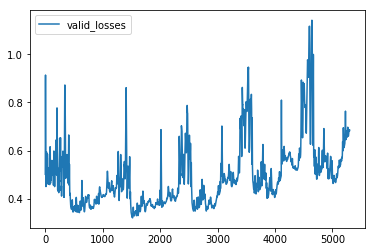

In [34]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

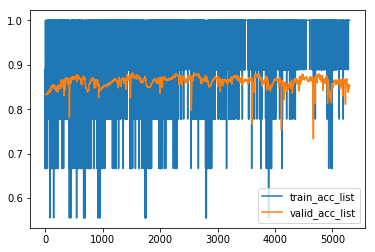

In [32]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()